<a href="https://colab.research.google.com/github/jesusgl86/Deep-Learning-Course/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [34]:
!ls "/content/drive/My Drive/Colab Notebooks"

 1_PyTorch_Basics.ipynb
 Building_a_Recurrent_Neural_Network_Step_by_Step.ipynb
'Copy of bysection.ipynb'
 Copy_of_GAN_MNIST_Data.ipynb
'Copy of M2H1P2.ipynb'
'Copy of Q3761.ipynb'
'Copy of Untitled14.ipynb'
 GAN.ipynb
 M2H3746.ipynb
 M2H857.ipynb
 M3H1.ipynb
 Object_Oriented_Programming_Basics.ipynb
'Session 1 - 8-8-22.ipynb'
 Untitled
 Untitled0.ipynb
'Untitled (1)'
 Untitled10.ipynb
 Untitled11.ipynb
 Untitled12.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 Untitled4.ipynb
 Untitled5.ipynb
 Untitled6.ipynb
 Untitled7.ipynb
 Untitled8.ipynb
 Untitled9.ipynb
'VAE_DeepLearning (1).ipynb'
'VAE_DeepLearning (3).ipynb'
'VAE_DeepLearning (4).ipynb'
 VAE_DeepLearning.ipynb


In [35]:
#Importing data
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [36]:
#Note that pixel values were transformed from the range [0, 1] to the range [-1, 1].
#Look at sample tensor values.
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [37]:
img.size(dim=1)

28

In [38]:
img.size()

torch.Size([1, 28, 28])

In [39]:
# function to denormalize and view the images. 
# This function will also be useful for viewing the generated images.
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


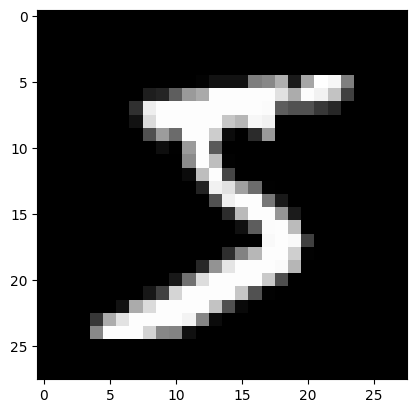

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [41]:
#Create a dataloader to load the images in batches.
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 0, 3, 0, 6, 1, 7, 2, 2, 2, 9, 4, 2, 5, 7, 7, 6, 4, 4, 9, 3, 3, 5, 7,
        9, 3, 5, 2, 4, 2, 4, 4, 8, 3, 8, 6, 8, 8, 0, 5, 5, 5, 6, 4, 1, 1, 8, 0,
        4, 6, 4, 3, 0, 8, 4, 1, 6, 4, 4, 1, 9, 9, 9, 4, 8, 5, 4, 9, 9, 3, 8, 5,
        0, 6, 4, 6, 5, 6, 2, 9, 9, 8, 8, 5, 2, 3, 4, 5, 0, 6, 1, 4, 4, 5, 8, 6,
        4, 1, 5, 5])


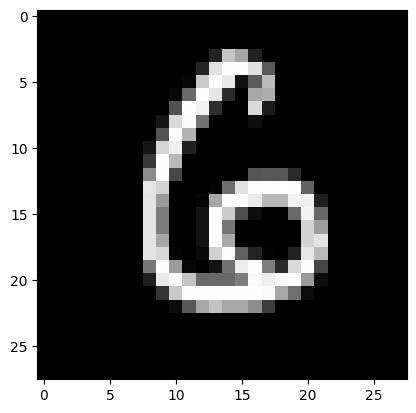

In [42]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [43]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [44]:
#Discriminator Network
image_size = 784
hidden_size = 256

In [45]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [46]:
# Move the discriminator model to the chosen device.
D.to(device);

In [47]:
# Genarator Network
latent_size = 64

In [48]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [49]:
G.to(device);

In [50]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [51]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score


In [52]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [53]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [54]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

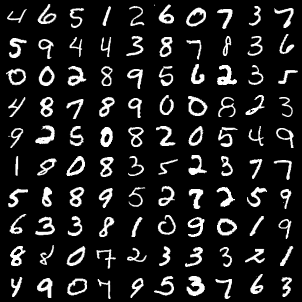

In [55]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


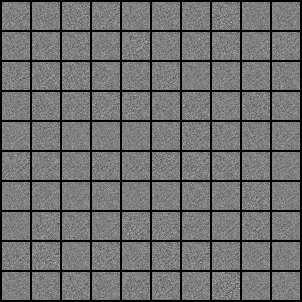

In [56]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))


In [57]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0414, g_loss: 4.3377, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.1736, g_loss: 4.6411, D(x): 0.97, D(G(z)): 0.12
Epoch [0/300], Step [600/600], d_loss: 0.0298, g_loss: 5.3669, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0821, g_loss: 4.0235, D(x): 0.98, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.0565, g_loss: 6.3229, D(x): 0.97, D(G(z)): 0.01
Epoch [1/300], Step [600/600], d_loss: 0.2153, g_loss: 3.6125, D(x): 0.92, D(G(z)): 0.09
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.4685, g_loss: 3.9389, D(x): 0.85, D(G(z)): 0.11
Epoch [2/300], Step [400/600], d_loss: 0.3850, g_loss: 2.9051, D(x): 0.88, D(G(z)): 0.11
Epoch [2/300], Step [600/600], d_loss: 0.1880, g_loss: 4.6634, D(x): 0.93, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1723, g_loss: 3.1391, D(x): 0.96, D(G(z)): 0.09
Epoch [3/300], Step [400/6

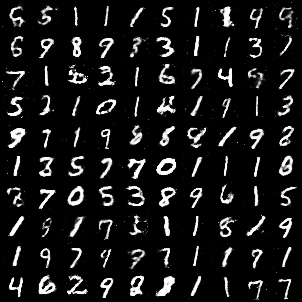

In [58]:
Image(os.path.join(sample_dir, 'fake_images-0300.png'))

In [81]:
fake_images = G(sample_vectors)
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
fake_fname = 'fake_imagesSample.png'
print('Saving', fake_fname)
save_image(denorm(fake_images[10:15]), os.path.join(sample_dir, fake_fname), nrow=5)

Saving fake_imagesSample.png


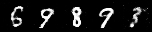

In [82]:
Image(os.path.join(sample_dir, 'fake_imagesSample.png'))

In [ ]:
#We going to re
#Create a dataloader to load the images in batches.
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

#Discriminator Network
image_size = 784
hidden_size = 256

import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
# Move the discriminator model to the chosen device.
D.to(device);
# Genarator Network
latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

G.to(device);
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
def train_discriminator2(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    fake_score = outputs 
    
    
    # Adversarial loss
    d_loss = torch.mean(fake_score) -torch.mean(real_score) 
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
n_critic=2

def train_generator2():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = -torch.mean(D(fake_images))

    if i % n_critic == 0:
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()
    return g_loss, fake_images   

import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir) 


from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))     


#sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images2(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images2-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images2-0000.png'))

In [27]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator2(images)
        g_loss, fake_images = train_generator2()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images2(epoch+1)